# A Notebook to automate the preprocessing of Sentinel-1 GRD products

In [1]:
#MODULES
import asf_search as asf
import getpass
from os import listdir
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from termcolor import colored
from zipfile import ZipFile
from os.path import join
from glob import iglob
import pandas as pd
import numpy as np
import subprocess
import snappy
import jpy
from PIL import Image
from tqdm import tqdm_notebook

pd.options.display.max_colwidth = 80

In [14]:
session = asf.ASFSession()

username = input('Username:')
password = getpass.getpass('Password:')

try:
    user_pass_session = asf.ASFSession().auth_with_creds(username, password)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

Username:mohammedkhalid056@gmail.com
Password:········
Success!


In [16]:
directory = r'D:\Disseration_Data\OilSpills\oilspill_50\asf'

granule = 'S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13'

result = asf.granule_search(granule)
# print(result)

result.download(path=directory, session=user_pass_session)

listdir(directory)

['S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13.iso.xml',
 'S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13.zip']

In [17]:
def output_view(product, band, min_value_VV, max_value_VV):
    """
    Creates visualisation of processed Sentinel-1 SAR data
    """
    band_data_list = []
    
    for i in band:
        band = product.getBand(i)
        w = band.getRasterWidth()
        h = band.getRasterHeight()
        band_data = np.zeros(w * h, np.float32)
        band.readPixels(0, 0, w, h, band_data)
        band_data.shape = h, w
        band_data_list.append(band_data)
        
    fig, (ax1) = plt.subplots(1, figsize=(12,12))
    ax1.imshow(band_data_list[0], cmap='gray', vmin=min_value_VV, vmax=max_value_VV)
    ax1.set_title(output_bands[0])
    
    for ax in fig.get_axes():
        ax.label_outer()
    
    return

In [4]:
# Call gpt -h from command line
# print(subprocess.Popen(['gpt', '-h'], stdout=subprocess.PIPE, universal_newlines=True).communicate()[0])
print(subprocess.Popen(['gpt', '-h', 'Apply-Orbit-File'], stdout=subprocess.PIPE, universal_newlines=True).communicate()[0])

Usage:
  gpt Apply-Orbit-File [options] 

Description:
  Apply orbit file


Source Options:
  -Ssource=<file>    Sets source 'source' to <filepath>.
                     This is a mandatory source.

Parameter Options:
  -PcontinueOnFail=<boolean>    Sets parameter 'continueOnFail' to <boolean>.
                                Default value is 'false'.
  -PorbitType=<string>          Sets parameter 'orbitType' to <string>.
                                Value must be one of 'Sentinel Precise (Auto Download)', 'Sentinel Restituted (Auto Download)', 'DORIS Preliminary POR (ENVISAT)', 'DORIS Precise VOR (ENVISAT) (Auto Download)', 'DELFT Precise (ENVISAT, ERS1&2) (Auto Download)', 'PRARE Precise (ERS1&2) (Auto Download)', 'Kompsat5 Precise'.
                                Default value is 'Sentinel Precise (Auto Download)'.
  -PpolyDegree=<int>            Sets parameter 'polyDegree' to <int>.
                                Default value is '3'.

Graph XML Format:
  <graph id="someGraphI

,Name,Sensing Mode,Product Type,Polarization,Height,Width,Available Bands
0,S1B_IW_GRDH_1SDV_20191013T032140_20191013T032209_018451_022C28_AA13,IW,GRDH,1SDV,19464,25210,"[Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV]"


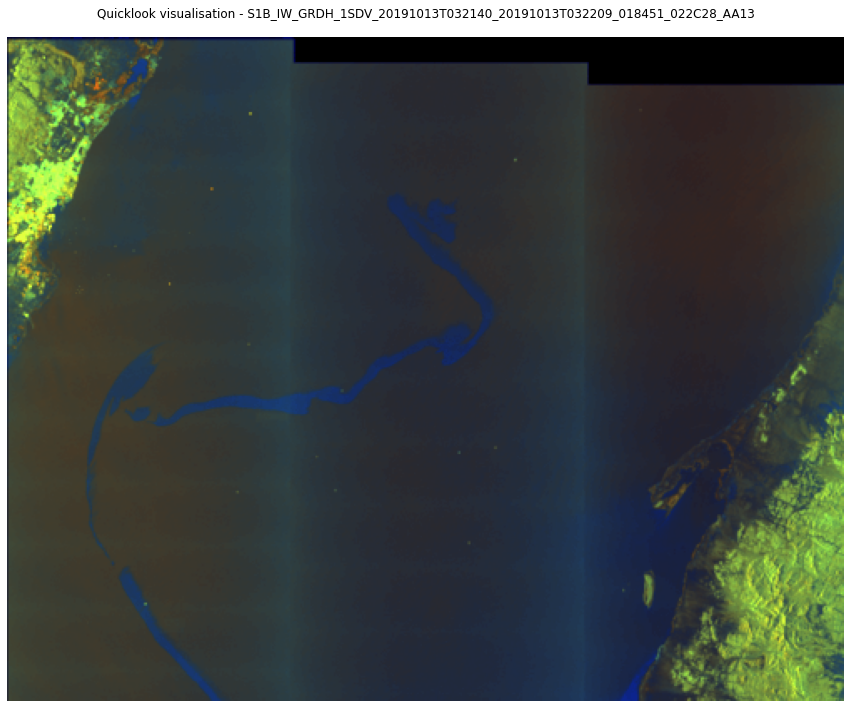

In [18]:
#define variables
oilspill_id = '50'
Acquisition_time = '20191013T032140'
pixel_spacing = '80'

# set target folder and extract metadata
product_path = fr"D:\Disseration_Data\OilSpills\oilspill_{oilspill_id}\asf"
input_s1_files = sorted(list(iglob(join(product_path, '**', '*S1*.zip'), recursive=True)))

name, sensing_mode, product_type, polarization, height, width, band_names = ([] for i in range(7))

for i in input_s1_files:
    sensing_mode.append(i.split("_")[3])
    product_type.append(i.split("_")[4])
    polarization.append(i.split("_")[-6])
    #read with snappy
    s1_read = snappy.ProductIO.readProduct(i)
    name.append(s1_read.getName())
    height.append(s1_read.getSceneRasterHeight())
    width.append(s1_read.getSceneRasterWidth())
    band_names.append(s1_read.getBandNames())

    df_s1_read = pd.DataFrame({'Name': name, 'Sensing Mode': sensing_mode, 'Product Type': product_type, 'Polarization': polarization, 'Height': height, 'Width': width, 'Available Bands': band_names})
    display(df_s1_read)
    
    #Display quicklook - First image
    with ZipFile(input_s1_files[0], 'r') as qck_look:
        qck_look = qck_look.open(name[0] + '.SAFE/preview/quick-look.png')
        img = Image.open(qck_look)
        plt.figure(figsize=(15,15))
        plt.title('Quicklook visualisation - '+ name[0] + '\n')
        plt.axis('off')
        plt.imshow(img);

In [19]:
#1 Subset

#choose corner
# x, y, width, height = 0, 3237, 8192, 8192

#Subset operator - snappy
parameters = snappy.HashMap()
parameters.put('copyMetadata', True)
# parameters.put('region', "%s, %s, %s, %s" % (x, y, width, height))
parameters.put('sourceBands','Amplitude_VV, Intensity_VV') 
subset = snappy.GPF.createProduct('Subset', parameters, s1_read)
list(subset.getBandNames())

#plot subset (follow VV - HH order)
# output_bands = ['Amplitude_VV']
# output_view(subset, output_bands, 20, 280)

['Amplitude_VV', 'Intensity_VV']

In [20]:
#2 apply orbit file operation - snappy
parameters = snappy.HashMap()
parameters.put('Apply-Orbit-File', True)
apply_orbit = snappy.GPF.createProduct('Apply-Orbit-File', parameters, subset)
print(colored('Orbit updated succesfully', 'green'))

# output_bands = ['Amplitude_VV']
# output_view(apply_orbit, output_bands, 41, 286)

Orbit updated succesfully


In [21]:
#3 themal noise removal operator - snappy
parameters = snappy.HashMap()
parameters.put('removeThermalNoise', True)
thermal_noise = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, apply_orbit)

#plot Thermal Noise Removal (follow VV - HH order)
# output_bands = ['Intensity_VV']
# output_view(thermal_noise, output_bands, 0.02, 99376.52)

In [22]:
#4 land sea mask
parameters = snappy.HashMap()
parameters.put('landMask', True)
land_mask = snappy.GPF.createProduct('Land-Sea-Mask', parameters, thermal_noise)

#plot land mask (follow VV - HH order)
# output_bands = ['Intensity_VV']
# output_view(land_mask, output_bands, 0.02, 99376.52)

In [23]:
#5 Radiometric Calibration operator - snappy
parameters = snappy.HashMap()
parameters.put('outputSigmaBand', True)
parameters.put('sourceBands', 'Intensity_VV')
parameters.put('selectedPolarisations', 'VH,VV')
parameters.put('outputImageScaleInDb', False)
calibrated = snappy.GPF.createProduct("calibration", parameters, land_mask)

# plot Thermal Noise Removal (follow VV - HH order)
# output_bands = ['Sigma0_VV']
# output_view(calibrated, output_bands, 0.00, 0.28)

In [24]:
#6A Speckle Filter operator - snappy
parameters = snappy.HashMap()
parameters.put('filter', 'Lee Sigma')
parameters.put('filterSizeX', 3)
parameters.put('filterSizeY', 3)
speckle = snappy.GPF.createProduct('Speckle-Filter', parameters, calibrated)

# Plot speckle filter (follow VV - VH order)
# output_bands = ['Sigma0_VV']
# output_view(speckle, output_bands, 0.00, 0.28)

In [25]:
#7A convert to dB operator
parameters = snappy.HashMap()
parameters.put('sourceBands', 'Sigma0_VV')
dB = snappy.GPF.createProduct('LinearToFromdB', parameters, speckle)

# Plot image in dB (follow VV - VH order)
# output_bands = ['Sigma0_VV_db']
# output_view(dB, output_bands, -40.00, -10.00)

In [26]:
#8A Undersample operator
parameters = snappy.HashMap()
parameters.put('method', 'LowPass Filtering')
parameters.put('outputImageBy', 'Pixel Spacing')
parameters.put('filterSize', '3x3')
parameters.put('rangeSpacing', '80')
parameters.put('azimuthSpacing', '80')
undersample = snappy.GPF.createProduct('Undersample', parameters, dB)

# Plot image in dB (follow VV - VH order)
# output_bands = ['Sigma0_VV_db']
# output_view(undersample, output_bands, -40.00, -10.00)

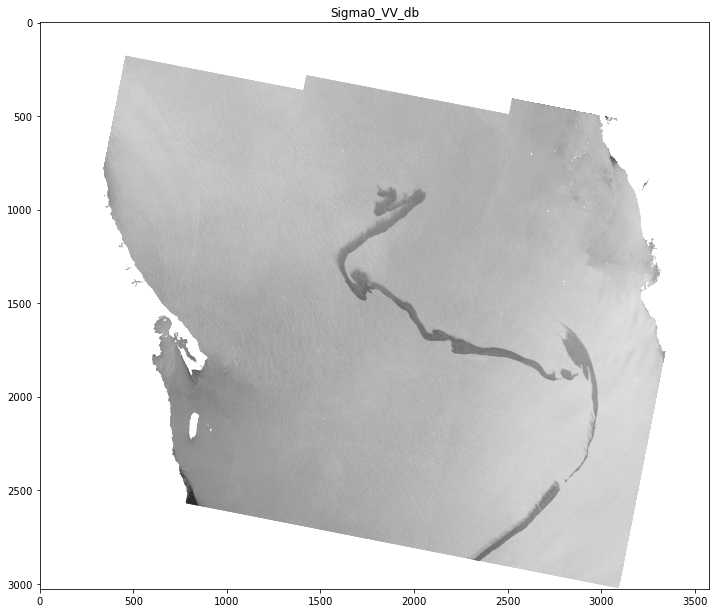

In [27]:
#9A Ellipsoid correction GG
parameters = snappy.HashMap()
parameters.put('mapProjection', 'AUTO:42001')
ellipsoid_correction = snappy.GPF.createProduct('Ellipsoid-Correction-GG', parameters, undersample)

# Plot image in dB (follow VV - VH order)
output_bands = ['Sigma0_VV_db']
output_view(ellipsoid_correction, output_bands, -40.00, -10.00)

In [ ]:
#A Write
#set output path and name
utm = 'UTM'
A_outpath_name = fr"D:\Disseration_Data\OilSpills\oilspill_{oilspill_id}\asf\{Acquisition_time}_Orb_Msk_Thm_Cal_Spk_db_{pixel_spacing}m_{utm}"

# Write Operator - snappy
snappy.ProductIO.writeProduct(ellipsoid_correction, A_outpath_name, 'GeoTIFF')
print(colored('Product succesfully saved in:', 'green'), A_outpath_name)

In [15]:
#6B Wind Field Estimation
parameters = snappy.HashMap()
parameters.put('sourceBands', 'Sigma0_VV')
parameters.put('windowSizeInKm', 0.6)

wind_estimated = snappy.GPF.createProduct("Wind-Field-Estimation", parameters, calibrated)

In [16]:
#6B Write
#set output path and name
product_name = 'wind_speed_Orb_Thm_Msk_Cal_06km_3'
outpath_name = fr"D:\Disseration_Data\OilSpills\oilspill_{oilspill_id}\{Acquisition_time}_{product_name}_{utm}_3"

# Write Operator - snappy
snappy.ProductIO.writeProduct(wind_estimated, outpath_name, 'BEAM-DIMAP')

print(colored('Product succesfully saved in:', 'green'), outpath_name)

Product succesfully saved in: D:\Disseration_Data\OilSpills\oilspill_51\20191013T032209_wind_speed_Orb_Thm_Msk_Cal_06km_3_UTM_3


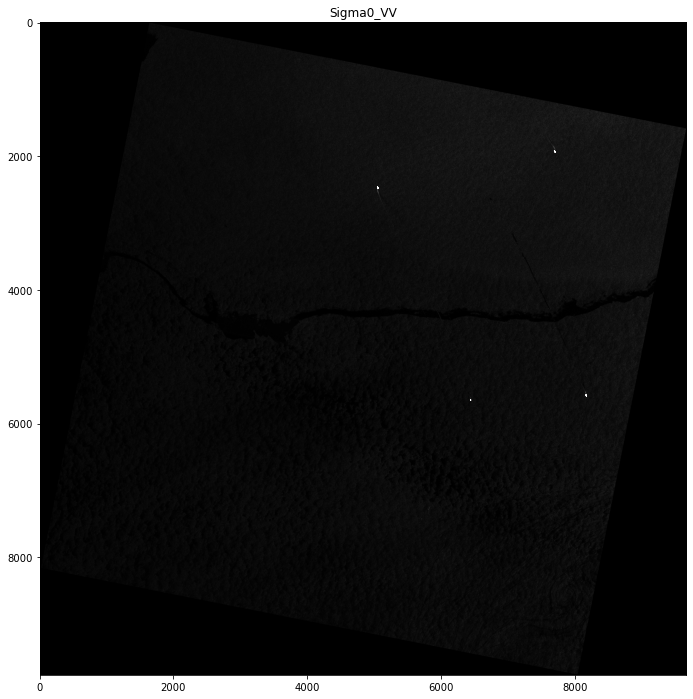

In [17]:
#7B Ellipsoid correction GG
B_product = snappy.ProductIO.readProduct(fr"D:\Disseration_Data\OilSpills\oilspill_{oilspill_id}\{Acquisition_time}_{product_name}_{utm}_3.dim")

parameters = snappy.HashMap()
parameters.put('mapProjection', 'AUTO:42001')
B_ellipsoid_correction = snappy.GPF.createProduct('Ellipsoid-Correction-GG', parameters, B_product)

# Plot image in dB (follow VV - VH order)
output_bands = ['Sigma0_VV']
output_view(B_ellipsoid_correction, output_bands, -40, -10)

In [18]:
#B Write
#set output path and name
product_name = 'wind_speed_Orb_Thm_Msk_Cal_06km_3'
outpath_name = fr"D:\Disseration_Data\OilSpills\oilspill_{oilspill_id}\{Acquisition_time}_{product_name}_{utm}_3"

# Write Operator - snappy
snappy.ProductIO.writeProduct(B_ellipsoid_correction, outpath_name, 'BEAM-DIMAP')

print(colored('Product succesfully saved in:', 'green'), outpath_name)

Product succesfully saved in: D:\Disseration_Data\OilSpills\oilspill_51\20191013T032209_wind_speed_Orb_Thm_Msk_Cal_06km_3_UTM_3
